# Credit Risk Analysis
As FinTech innovations pave the way for more people to have access to financial services, so too must the financial service providers find means to evaluate how creditworthy a person or entity is. Faster and in a more scalable, sustainable manner while retaining the robustness of their credity analysis system. 

In this notebook we explore the creation of a credit risk scoreboard using logistic regression. We will process a prepared dataset 

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = "data/Loan_Data.csv"
df = pd.read_csv(data_path)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
dev, val, holdout = np.split(
    df.sample(frac=1, random_state=1),
              [
                  int(.5 * len(df)), 
                  int(.8 * len(df))
              ]
    )

print(f"""Development group: {len(dev)}
Validation group: {len(val)}
Holdout group: {len(holdout)}""")

Development group: 5000
Validation group: 3000
Holdout group: 2000


C:\Users\User\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [4]:
# Check for sampling errors
print(f"""
Population Default Rate: {round(sum(df.default) * 100 / len(df), 2)}%
Development Sample Default Rate: {round(sum(dev.default) * 100 / len(dev), 2)}%
Validation Sample Default Rate: {round(sum(val.default) * 100 / len(val), 2)}%
Holdout Sample Default Rate: {round(sum(holdout.default) * 100 / len(holdout), 2)}%
""")


Population Default Rate: 18.51%
Development Sample Default Rate: 18.48%
Validation Sample Default Rate: 18.8%
Holdout Sample Default Rate: 18.15%



As seen, simple random sampling is effective in sampling for default rates. Alternatively, we can use stratified random sampling to make the default rate for each group (i.e., development, validation and holdout) more consistent.

In [5]:
from sklearn.model_selection import train_test_split as tts

In [6]:
dev, temp = tts(
    df, 
    test_size = 0.5, 
    stratify = df.default,
    random_state = 1
)

In [7]:
val, holdout = tts(
    temp,
    test_size = 0.4,
    stratify = temp.default,
    random_state = 1
)

In [8]:
print(f"""
Population Default Rate: {round(sum(df.default) * 100 / len(df), 2)}%
Development Sample Default Rate: {round(sum(dev.default) * 100 / len(dev), 2)}%
Validation Sample Default Rate: {round(sum(val.default) * 100 / len(val), 2)}%
Holdout Sample Default Rate: {round(sum(holdout.default) * 100 / len(holdout), 2)}%
""")


Population Default Rate: 18.51%
Development Sample Default Rate: 18.5%
Validation Sample Default Rate: 18.53%
Holdout Sample Default Rate: 18.5%



## Part 1: Preliminary Investigation on Development Dataset

In [11]:
dev.describe(include = "all")

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.924076e+06,1.463600,4166.299904,8780.301994,70033.145403,4.552000,638.119000,0.185000
std,2.288148e+06,1.741862,1435.044371,6698.144495,20164.543357,1.561084,60.405399,0.388336
min,1.000324e+06,0.000000,57.348647,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.913551e+06,0.000000,3135.359986,4192.718392,56686.278268,3.000000,598.000000,0.000000
50%,4.932271e+06,1.000000,4052.171922,6756.589651,70220.565090,5.000000,638.000000,0.000000
75%,6.871387e+06,2.000000,5058.564804,11496.912522,83316.641957,6.000000,679.000000,0.000000
max,8.996751e+06,5.000000,10467.732060,43688.784100,145404.751500,10.000000,850.000000,1.000000


### Outlier Treatment

Text(0.5, 0, 'fico_score')

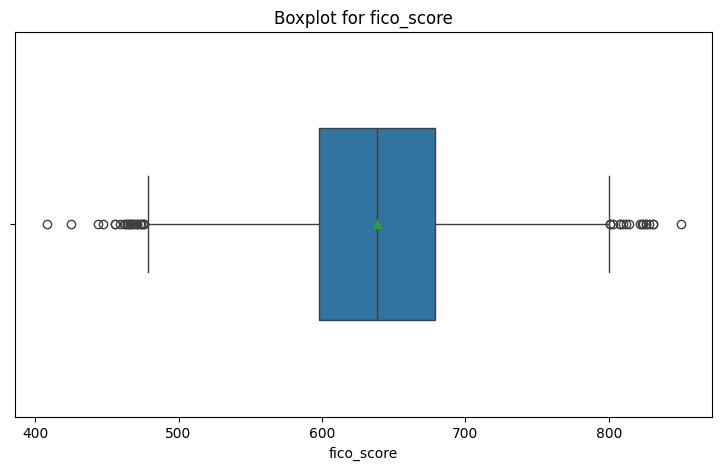

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns  # built on top of plt for better visualization
%matplotlib inline

x = "fico_score"
plt.figure(figsize=(9,5))
boxplot = sns.boxplot(
    x = x,
    data = dev,
    showmeans = True,
    width = 0.5, 
    # palette = "colorblind"
)
plt.title(f"Boxplot for {x}")
plt.xlabel(f"{x}")

After investigating the development dataset for outliers across all columns, we observed that outliers are persistent. As expected, income and fico score have similar boxplots. Common treatment for outliers is to equate them to their corresponding control limits (e.g., upper, lower). However, for this simple modelling task, we will not perform any outlier treatment.

Next, we investigate the dataset for any missing value. 

### Missing Value Imputation

In [13]:
missing_df = dev.isnull().sum(axis=0)
missing_df

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

We have a complete dataset; therefore, no action is needed. Otherwise, there are various imputation methods:
- initiate NAs to zero
- central measures of tendency (e.g., mean, median, mode)
- k-nearest neighbors
- regression

Now that we have prepared our dataset, we can now start with the modelling of our development group. First, we will derive meaningful ratios (e.g., debt income ratio, loan income ratio) from the outstanding raw values. 

In [15]:
dev["debt_income_ratio"] = dev["total_debt_outstanding"] / dev["income"]
dev["loan_income_ratio"] = dev["loan_amt_outstanding"] / dev["income"]
dev.describe(include="all")

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.924076e+06,1.463600,4166.299904,8780.301994,70033.145403,4.552000,638.119000,0.185000,0.124406,0.059524
std,2.288148e+06,1.741862,1435.044371,6698.144495,20164.543357,1.561084,60.405399,0.388336,0.082883,0.010735
min,1.000324e+06,0.000000,57.348647,31.652732,1000.000000,0.000000,408.000000,0.000000,0.010000,0.020569
25%,2.913551e+06,0.000000,3135.359986,4192.718392,56686.278268,3.000000,598.000000,0.000000,0.068887,0.052079
50%,4.932271e+06,1.000000,4052.171922,6756.589651,70220.565090,5.000000,638.000000,0.000000,0.097702,0.059479
75%,6.871387e+06,2.000000,5058.564804,11496.912522,83316.641957,6.000000,679.000000,0.000000,0.163687,0.066879
max,8.996751e+06,5.000000,10467.732060,43688.784100,145404.751500,10.000000,850.000000,1.000000,0.404561,0.095885


## Part 2: Bin Cutoffs
Next we will bucket the samples into range of values (i.e., bins) that are specific for each variable. Bins can be important in modelling, especially when the relationship of the variables being examined is non-linear. By evaluating a predictor variable based on a range of values, we can better 'smoothen' the relationship. For example, A: 1->1, B: 2->2, C: 3-> 6, D: 4->7. By grouping A with B and C with D, we can have a 'smoother' relationship.

This is where domain knowledge comes into play. The goal is to determine what range would best represent a certain demographic given a specified variable. In addition, we must also consider that each bin has both target and non-target (i.e., default and non-default) samples to avoid overfitting. 


### **1. credit\_lines\_outstanding** (0–5, discrete)

**Idea:** This is already discrete, so binning can be done as small groups.

```
Bin 1: 0 lines
Bin 2: 1–2 lines
Bin 3: 3–5 lines
```

---

### **2. loan\_amt\_outstanding** (≈ \$47 – \$10,750)

Median is \~\$4,052, 75% is \~\$5,053.

```
Bin 1: < $3,000
Bin 2: $3,000 – $4,500
Bin 3: $4,500 – $6,000
Bin 4: > $6,000
```

---

### **3. total\_debt\_outstanding** (≈ \$32 – \$43,689)

Median \~\$6,732, 75% \~\$11,272.

```
Bin 1: < $5,000
Bin 2: $5,000 – $8,000
Bin 3: $8,000 – $12,000
Bin 4: > $12,000
```

---

### **4. income** (\$1,000 – \$148,412, median \~\$70k)

Big range. Wide bins make more sense here.

```
Bin 1: < $50,000
Bin 2: $50,000 – $70,000
Bin 3: $70,000 – $90,000
Bin 4: > $90,000
```

---

### **5. years\_employed** (0–10, median 5)

Discrete integers. Small range.

```
Bin 1: 0–2 years
Bin 2: 3–5 years
Bin 3: 6–8 years
Bin 4: 9–10 years
```

---

### **6. fico\_score** (408 – 850, median \~638)

Industry categories for FICO usually guide bins here.

```
Bin 1: < 580   (Poor)
Bin 2: 580–669 (Fair)
Bin 3: 670–739 (Good)
Bin 4: ≥ 740   (Very Good / Excellent)
```

---

### **7. debt\_income\_ratio** (0.01 – 0.40, median 0.097)

This is the **DTI** measure; values above \~0.4 are rare.

```
Bin 1: ≤ 0.07
Bin 2: 0.07 – 0.10
Bin 3: 0.10 – 0.16
Bin 4: > 0.16
```

---

### **8. loan\_income\_ratio** (0.012 – 0.102, median \~0.06)

Similar to PTI; very small range.

```
Bin 1: ≤ 0.052
Bin 2: 0.052 – 0.060
Bin 3: 0.060 – 0.067
Bin 4: > 0.067
```

---

In [22]:
bin_specs = {
    'credit_lines_outstanding': [-1, 0, 2, 5],
    'loan_amt_outstanding': [-float('inf'), 3000, 4500, 6000, float('inf')],
    'total_debt_outstanding': [-float('inf'), 5000, 8000, 12000, float('inf')],
    'income': [-float('inf'), 50000, 70000, 90000, float('inf')],
    'years_employed': [-1, 2, 5, 8, 10], 
    'fico_score': [-float('inf'), 580, 670, 740, float('inf')],
    'debt_income_ratio': [-float('inf'), 0.07, 0.10, 0.16, float('inf')], 
    'loan_income_ratio': [-float('inf'), 0.052, 0.060, 0.067, float('inf')]
}

In [23]:
# default percentage counter
def default_rate_per_bin(df, col_bin):
    return (
        df.groupby(col_bin, observed = False)['default']
        .agg(['count', 'sum', 'mean'])
        .rename(columns = {'sum': 'defaults', 'mean': 'default_rate'})
        .reset_index()
    )

# create new columns for bin ranges
for col, bins in bin_specs.items():
    dev[col + '_bin'] = pd.cut(dev[col], bins=bins)

# show default rate per bin
for col in bin_specs.keys():
    print(f"\n --- {col.upper()} ---")
    result = default_rate_per_bin(dev, col+"_bin")
    print(result)


 --- CREDIT_LINES_OUTSTANDING ---
  credit_lines_outstanding_bin  count  defaults  default_rate
0                      (-1, 0]   2054         0      0.000000
1                       (0, 2]   1773         5      0.002820
2                       (2, 5]   1173       920      0.784314

 --- LOAN_AMT_OUTSTANDING ---
  loan_amt_outstanding_bin  count  defaults  default_rate
0           (-inf, 3000.0]   1054       136      0.129032
1         (3000.0, 4500.0]   2029       328      0.161656
2         (4500.0, 6000.0]   1385       312      0.225271
3            (6000.0, inf]    532       149      0.280075

 --- TOTAL_DEBT_OUTSTANDING ---
  total_debt_outstanding_bin  count  defaults  default_rate
0             (-inf, 5000.0]   1652         5      0.003027
1           (5000.0, 8000.0]   1308        20      0.015291
2          (8000.0, 12000.0]    859        76      0.088475
3             (12000.0, inf]   1181       824      0.697714

 --- INCOME ---
           income_bin  count  defaults  defaul

## **Part 3: Weight of Evidence (WOE)**
---

### **Significance**

* **Logistic regression** assumes a *linear* relationship between the independent variable and the log-odds of default.
* Raw variables often have **non-linear** or inconsistent relationships.
* **WOE transformation** makes the predictor monotonic with default risk and stabilizes model performance.
* It also handles categorical data cleanly after binning.

---

### **Steps**

1. Use your binned variables (from the last step).
2. For each bin:

   * Count **Good** (non-default) and **Bad** (default) observations.
   * Compute WOE =

     $$
     \text{WOE} = \ln\left(\frac{\text{\% Good in bin}}{\text{\% Bad in bin}}\right)
     $$
3. Replace the bin values with the computed WOE value for logistic regression input.


### **What you’ll see**

For each binned variable, you’ll get something like:

```
loan_amt_outstanding_bin  count  good   bad       woe       iv
(-inf, 3000]               2200  2100   100   0.7654   0.0453
(3000, 4500]               2500  2300   200   0.3211   0.0224
(4500, 6000]               2800  2400   400  -0.2108   0.0102
(6000, inf]                2500  2000   500  -0.5124   0.0521
```

---

### **How we’ll use this**

* For the **logistic regression** model, we’ll replace each bin with its **WOE value**. This turns our categorical bins into continuous predictors with a monotonic relationship to default probability.
* The **IV (Information Value)** will help us decide if a variable is worth keeping:

  * **< 0.02** → Not predictive
  * **0.02–0.1** → Weak predictor
  * **0.1–0.3** → Medium predictor
  * **> 0.3** → Strong predictor

---



In [27]:
def compute_woe_iv(df, var_bin, target = 'default', bins = None, k = 0.5):
    grouped = df.groupby(var_bin, observed = False)[target].agg(['count', 'sum'])
    grouped['good'] = grouped['count'] - grouped['sum']
    grouped['bad'] = grouped['sum']

    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()

    # smoothing to avoid zero counts
    grouped['%good'] = (grouped['good'] + k) / (total_good + 2*k)
    grouped['%bad'] = (grouped['bad'] + k) / (total_bad + 2*k)

    # Laplace smoothing to avoid zero division
    grouped['woe'] = np.log(
        grouped['%good'] / grouped['%bad']
    )

    grouped['iv'] = ( grouped['%good'] - grouped['%bad']  ) * grouped['woe']
    return grouped.reset_index()

In [29]:
woe_tables = {}
for col in bin_specs.keys():
    col_bin = col + '_bin'
    woe_table = compute_woe_iv(dev, col_bin)
    woe_tables[col] = woe_table

    # Uncomment the code below to see the initial results
    # print(f"\n--- {col.upper()} ---")
    # print(woe_table)

**Extreme WOE Problem**
- some bins have zero default counts, making their woe values explode
- to resolve this, you would need to perform bin merging
- this ensures that each bin has a minimum number of default samples (e.g., at least one)

Since we are still observing extremes, this implies that our bins contain imbalanced groups for either defaults or non-defaults. From the adjusted WOE scores, we will merge bins with adjacent bins if their corresponding WOE is unusual (i.e., |WOE| > 3). 


### Suggested fix:
| Variable                       | Current Problem                       | Adjustment                                             |
| ------------------------------ | ------------------------------------- | ------------------------------------------------------ |
| **credit\_lines\_outstanding** | First bin has WOE = 7.54, 0 bads      | Merge bins (-1,0] and (0,2], re-check monotonicity     |
| **loan\_amt\_outstanding**     | Already fine, low IV                  | Keep as is, but check if further compression is needed |
| **total\_debt\_outstanding**   | First two bins very high WOE          | Merge first 2 bins, last two bins separately           |
| **income**                     | Very low IV                           | Drop entirely                                          |
| **years\_employed**            | Small bin with 54 people, extreme WOE | Merge last bin with (5,8]                              |
| **fico\_score**                | OK                                    | Keep as is                                             |
| **debt\_income\_ratio**        | First three bins perfect separation   | Merge first 3 bins together                            |
| **loan\_income\_ratio**        | Fine                                  | Keep as is                                             |


Now, we define new ranges for our bins.

In [30]:
bin_specs = {
    'credit_lines_outstanding': [-1, 2, 5],
    'loan_amt_outstanding': [-float('inf'), 3000, 4500, 6000, float('inf')],
    'total_debt_outstanding': [-float('inf'), 8000, 12000, float('inf')],
    'income': [-float('inf'), 50000, 70000, 90000, float('inf')],
    'years_employed': [-1, 2, 5, 10],
    'fico_score': [-float('inf'), 580, 670, 740, float('inf')],
    'debt_income_ratio': [-float('inf'), 0.10, 0.16, float('inf')],
    'loan_income_ratio': [-float('inf'), 0.052, 0.060, 0.067, float('inf')]
}

# Apply binning
for col, bins in bin_specs.items():
    dev[col + '_bin'] = pd.cut(dev[col], bins=bins, include_lowest=True)

# Uncomment the code below to examine the results of the modified bins
# woe_tables = {}
# for col in bin_specs.keys():
#     col_bin = col + '_bin'
#     woe_table = compute_woe_iv(new_df, col_bin)
#     woe_tables[col] = woe_table
#     print(f"\n--- {col.upper()} ---")
#     print(woe_table)

You will see from the results that the modified bins only slightly improved. This shows the complexity of designing a credit risk scorecard through logistic regression, in which you would have to have industry knowledge and a good grasp of the data characteristics you are working with. There remains numerous ways to optimize the bins, but for now we will work with our current numbers.

We will also apply outlier treatment wherein we will set min and max values to avoid overfitting issues.

## Model training

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# WOE dictionary: bin range to corresp. WOE value
woe_dict = {
    'credit_lines_outstanding_bin': {
        '(-1.001, 2.0]': 5.441,
        '(2.0, 5.0]': -2.717
    },
    'loan_amt_outstanding_bin': {
        '(-inf, 3000.0]': 0.359,
        '(3000.0, 4500.0]': 0.129,
        '(4500.0, 6000.0]': -0.212,
        '(6000.0, inf]': -0.471
    },
    'total_debt_outstanding_bin': {
        '(-inf, 8000.0]': 3.260,
        '(8000.0, 12000.0]': 0.848,
        '(12000.0, inf]': -2.397
    },
    'income_bin': {
        '(-inf, 50000.0]': 0.017,
        '(50000.0, 70000.0]': 0.071,
        '(70000.0, 90000.0]': -0.054,
        '(90000.0, inf]': -0.047
    },
    'years_employed_bin': {
        '(-1.001, 2.0]': -1.041,
        '(2.0, 5.0]': -0.142,
        '(5.0, 10.0]': 1.226
    },
    'fico_score_bin': {
        '(-inf, 580.0]': -1.201,
        '(580.0, 670.0]': 0.090,
        '(670.0, 740.0]': 1.045,
        '(740.0, inf]': 1.998
    },
    'debt_income_ratio_bin': {
        '(-inf, 0.1]': 7.773,
        '(0.1, 0.16]': 6.920,
        '(0.16, inf]': -2.455
    },
    'loan_income_ratio_bin': {
        '(-inf, 0.052]': 0.629,
        '(0.052, 0.06]': 0.187,
        '(0.06, 0.067]': -0.148,
        '(0.067, inf]': -0.492
    }
}

# Clip extreme values to avoid -inf/inf in binning
clip_limits = {
    'credit_lines_outstanding': (0, 5),
    'loan_amt_outstanding': (0, 6000),
    'total_debt_outstanding': (0, 20000),
    'income': (0, 200000),
    'years_employed': (0, 10),
    'fico_score': (300, 850),
    'debt_income_ratio': (0, 1),
    'loan_income_ratio': (0, 1)
}

for col, (min_val, max_val) in clip_limits.items():
    dev[col] = dev[col].clip(lower=min_val, upper=max_val)

# Map WOE values
for col in bin_specs.keys():
    bin_col = col + '_bin'
    woe_col = col + '_woe'
    
    # Ensure bins are strings
    dev[bin_col] = dev[bin_col].astype(str)
    
    # Map using woe_dict; fill NaN with 0
    dev[woe_col] = dev[bin_col].map(woe_dict[bin_col]).fillna(0)

# Verify mapping
for col in bin_specs.keys():
    print(col + '_woe', dev[col + '_woe'].unique())

# Prepare data for GLM
woe_features = [col + '_woe' for col in bin_specs.keys()]
X = dev[woe_features]
y = dev['default']

X = sm.add_constant(X)  # Add intercept
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
model = glm_binom.fit()
print(model.summary())

# Predict probability of default
dev['pd'] = model.predict(X)


credit_lines_outstanding_woe [ 5.441 -2.717]
loan_amt_outstanding_woe [-0.212  0.359  0.129 -0.471]
total_debt_outstanding_woe [ 0.848  3.26  -2.397]
income_woe [-0.054  0.017  0.071 -0.047]
years_employed_woe [ 1.226 -0.142 -1.041]
fico_score_woe [ 0.09   1.998  1.045 -1.201]
debt_income_ratio_woe [ 6.92   7.773 -2.455]
loan_income_ratio_woe [-0.148  0.629 -0.492  0.187]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -453.83
Date:                Thu, 14 Aug 2025   Deviance:                       907.66
Time:                        23:15:26   Pearson chi2:                 1.

Now that you have a basic (generalized) model for predicting defaults, you can then test it out on your validation dataset and make further adjustments to your bins, correspondingly. Afterwards, you will use the modified model to perform a final inference on your test dataset and report the performance results.